<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/TEC_OUR_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/InfluenceAnalysis/TEC/TECOur.csv')
df = df.sample(frac=1,random_state=32)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



In [7]:
df.head()

,tweets,emotion
19554,smoothies are the best at any time any temper...,2
9801,Rain tomorrow that means curly hair,0
13413,Bout to lay it down im tired Tmrws gonna ...,0
3398,hahaha run a marathon hopin to go abroad to ...,0
9536,Christmas shopping in tkmax with Deck The Hall...,0


In [9]:
print(df.emotion.unique())
no_labels=6

[2 0 1 3 4 5]


In [10]:
category_dict = {}
for i in range(no_labels):
  category_dict[i]=[0 for j in range(no_labels)]
  category_dict[i][i]=1
data_tweet = [str(x).lower().split() for x in df['tweets']]
data_cat = np.array([np.array(category_dict[x]) for x in df['emotion']])
print(data_cat[:5])

[[0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [11]:
print(data_tweet[:5])
print(data_cat[:5])

[['smoothies', 'are', 'the', 'best', 'at', 'any', 'time', 'any', 'temperature', 'we', 'have', 'no', 'smoothie', 'availability', 'at', 'lehigh'], ['rain', 'tomorrow', 'that', 'means', 'curly', 'hair'], ['bout', 'to', 'lay', 'it', 'down', 'im', 'tired', 'tmrws', 'gonna', 'feel', 'so', 'long', 'considering', 'i', 'have', 'not', 'had', 'school', 'for', 'a', 'week'], ['hahaha', 'run', 'a', 'marathon', 'hopin', 'to', 'go', 'abroad', 'to', 'do', 'some'], ['christmas', 'shopping', 'in', 'tkmax', 'with', 'deck', 'the', 'halls', 'playing', 'in', 'the', 'background']]
[[0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [12]:
# Parameters
Min_count = 0
Embedding_size = 200
Window_size = 5
Negative_sampling = 00

In [13]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [14]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/InfluenceAnalysis/glove/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [16]:
batch_size = 500
Max_input_size = max([len(x) for x in data_tweet])
print(Max_input_size)

51


In [17]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = np.array(data_cat[k*(batch_size):(k+1)*(batch_size)])
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = np.array(data_cat[k*(batch_size):(k+1)*(batch_size)])
      yield (temp,tempres)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(data_tweet, data_cat)
X_train=[]
X_test=[]
y_train=[]
y_test=[]
counter=0
for train_index, test_index in sss.split(data_tweet, data_cat):
  print("TRAIN:", train_index, "TEST:", test_index)
  for i in train_index:
    X_train+=[data_tweet[i]]
    y_train+=[data_cat[i]]

  for j in test_index:
    X_test+=[data_tweet[j]]
    y_test+=[data_cat[j]]

 # X_train, X_test = data_tweet[train_index], data_tweet[test_index]
 # y_train, y_test = data_cat[train_index], data_cat[test_index]
print(X_train[:5])
print(y_train[:5])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X_train, y_train)
x_train=[]
X_val=[]
Y_train=[]
y_val=[]
for train_index1, test_index1 in sss.split(X_train, y_train):
  print("TRAIN:", train_index1, "TEST:", test_index1)
  for i in train_index1:
    x_train+=[X_train[i]]
    Y_train+=[y_train[i]]

  for j in test_index1:
    X_val+=[X_train[j]]
    y_val+=[y_train[j]]
X_train=x_train
y_train=Y_train
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))
print(X_train[:5])
print(y_train[:5])
result_table = [0,0,0,0,0,0,0,0,0]

TRAIN: [ 4990  8232 16430 ...  1782 14725 11582] TEST: [ 9096 15406 12733 ... 11184  9511 11639]
[['what', 'the', 'hell', 'has', 'gotten', 'in', 'to', 'you', 'like', 'legit', 'your', 'an', 'ass', 'now'], ['i', 'do', 'not', 'have', 'cell', 'phone', 'service', 'so', 'i', 'am', 'tweeting', 'you', 'are', 'you', 'still', 'down', 'for', 'some', 'shopping'], ['there', 'is', 'a', 'mysterious', 'ticking', 'noise', 'somewhere', 'by', 'my', 'bed', 'not', 'the', 'puppet', 'pals', 'kind', 'scared'], ['have', 'a', 'dream', 'your', 'breath', 'smells', 'really', 'bad', 'wake', 'up', 'with', 'cat', 'throw', 'up', 'on', 'your', 'pillow', 'wtf'], ['who', 'u', 'hey', 'there', 'long', 'time', 'no', 'see', 'speak', 'of', 'the', 'week']]
[array([0, 1, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0])]
TRAIN: [ 4502 13470 16740 ...  3004  1741 11001] TEST: [10612  3057 12008 ...  2972  6445 13573]
13469
13469
4210
4210
3368
3368
[['bahaha'

In [19]:
epochs = 30

In [20]:
from keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recalls = true_positives / (possible_positives + K.epsilon())
        return recalls
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precisions = true_positives / (predicted_positives + K.epsilon())
        return precisions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [21]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(6, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
sg_train_gen=vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size)
sg_val_gen=vec_gen(w2v_sg,vocab_sg,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_sg_bi = model_sg_bi.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/30
27/27 [==============================] - 44s 1s/step - loss: 1.7387 - accuracy: 0.3116 - f1: 0.0073 - precision: 0.0468 - recall: 0.0044 - val_loss: 1.5640 - val_accuracy: 0.3877 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
27/27 [==============================] - 39s 1s/step - loss: 1.5579 - accuracy: 0.3948 - f1: 0.0414 - precision: 0.6044 - recall: 0.0221 - val_loss: 1.5160 - val_accuracy: 0.4066 - val_f1: 0.1285 - val_precision: 0.6024 - val_recall: 0.0720
Epoch 3/30
27/27 [==============================] - 38s 1s/step - loss: 1.5068 - accuracy: 0.4126 - f1: 0.1699 - precision: 0.6216 - recall: 0.1013 - val_loss: 1.4683 - val_accuracy: 0.4317 - val_f1: 0.2165 - val_precision: 0.6734 - val_recall: 0.1291
Epoch 4/30
27/27 [==============================] - 38s 1s/step - loss: 1.4413 - accuracy: 0.4402 - f1: 0.2602 - precision: 0.6649 - recall: 0.1642 - val_loss: 1.4208 - val_accuracy: 0.4511 - val_f1: 0.2608 - val_precision: 0.6955 -

In [22]:

model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(6, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
cbow_train_gen=vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size)
cbow_val_gen=vec_gen(w2v_cbow,vocab_cbow,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_cbow_bi = model_cbow_bi.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)
result_table[4]=history[1]
print("CBOW_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/30
27/27 [==============================] - 44s 2s/step - loss: 1.7293 - accuracy: 0.3134 - f1: 0.0174 - precision: 0.0417 - recall: 0.0124 - val_loss: 1.5635 - val_accuracy: 0.3877 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
27/27 [==============================] - 39s 1s/step - loss: 1.5558 - accuracy: 0.3956 - f1: 0.0606 - precision: 0.5541 - recall: 0.0337 - val_loss: 1.5274 - val_accuracy: 0.3934 - val_f1: 0.0838 - val_precision: 0.6466 - val_recall: 0.0449
Epoch 3/30
27/27 [==============================] - 40s 1s/step - loss: 1.5214 - accuracy: 0.3965 - f1: 0.1415 - precision: 0.6343 - recall: 0.0805 - val_loss: 1.4828 - val_accuracy: 0.4354 - val_f1: 0.2522 - val_precision: 0.6245 - val_recall: 0.1580
Epoch 4/30
27/27 [==============================] - 38s 1s/step - loss: 1.4573 - accuracy: 0.4279 - f1: 0.2472 - precision: 0.6570 - recall: 0.1560 - val_loss: 1.4459 - val_accuracy: 0.4374 - val_f1: 0.2687 - val_precision: 0.6632 -

In [23]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(6, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
glove_train_gen=glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size)
glove_val_gen=glove_gen(vocab_glove,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_glove_bi = model_glove_bi.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/30
27/27 [==============================] - 23s 720ms/step - loss: 1.7090 - accuracy: 0.2838 - f1: 0.0321 - precision: 0.1831 - recall: 0.0187 - val_loss: 1.4704 - val_accuracy: 0.4140 - val_f1: 0.1792 - val_precision: 0.7531 - val_recall: 0.1017
Epoch 2/30
27/27 [==============================] - 18s 680ms/step - loss: 1.4289 - accuracy: 0.4448 - f1: 0.2807 - precision: 0.6745 - recall: 0.1784 - val_loss: 1.2874 - val_accuracy: 0.5014 - val_f1: 0.3724 - val_precision: 0.7381 - val_recall: 0.2494
Epoch 3/30
27/27 [==============================] - 18s 660ms/step - loss: 1.2841 - accuracy: 0.5090 - f1: 0.4051 - precision: 0.7100 - recall: 0.2848 - val_loss: 1.1937 - val_accuracy: 0.5446 - val_f1: 0.4677 - val_precision: 0.7424 - val_recall: 0.3417
Epoch 4/30
27/27 [==============================] - 18s 679ms/step - loss: 1.1840 - accuracy: 0.5470 - f1: 0.4845 - precision: 0.7305 - recall: 0.3631 - val_loss: 1.1538 - val_accuracy: 0.5586 - val_f1: 0.5161 - val_precision: 0.7172 -

	BiLstm
sg [0, 0.4819999933242798, 0]
cbow [0, 0.49799999594688416, 0]
glove [0, 0.5759999752044678, 0]
{'loss': [1.6757164001464844, 1.5507323741912842, 1.4926048517227173, 1.4325486421585083, 1.3867754936218262, 1.3573514223098755, 1.3336211442947388, 1.3214638233184814, 1.3121672868728638, 1.3022141456604004, 1.292113184928894, 1.2815624475479126, 1.269182562828064, 1.253994345664978, 1.2494386434555054, 1.2381738424301147, 1.232069730758667, 1.2216646671295166, 1.2042527198791504, 1.1870602369308472, 1.1629092693328857, 1.1341934204101562, 1.109148621559143, 1.0878819227218628, 1.0637648105621338, 1.0497266054153442, 1.0338020324707031, 1.0151489973068237, 0.9964094161987305, 0.9681864976882935], 'accuracy': [0.36229628324508667, 0.39318519830703735, 0.4171110987663269, 0.4484444558620453, 0.467851847410202, 0.48355555534362793, 0.4923703670501709, 0.49755555391311646, 0.4982222318649292, 0.5029629468917847, 0.5097036957740784, 0.5134074091911316, 0.5196296572685242, 0.522074103355

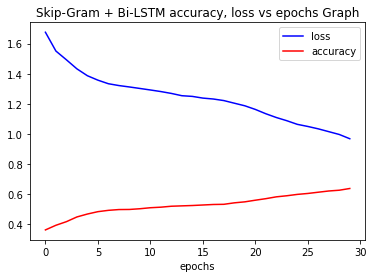

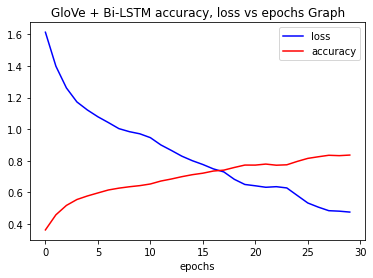

In [24]:
print("\tBiLstm")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()